<footer id="footer"></footer>

<p align="center"><b>Сегментация изображений. PyTorch</b></h3>
<p align="center"><img src="https://i.ibb.co/4gdr58T/nevrologiya.jpg" alt="nevrologiya" border="0"></p>








## Контекст

В этом задании нам предстоит решить задачу сегментации медицинских снимков. 
Нам необходимо ответить **на следующие вопросы**:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?


---
    
 <font size="2"> [Baseline](https://colab.research.google.com/drive/1ILkwB-wz_eFUd6fvr4I_zB1R0ko0WtsR?usp=sharing#scrollTo=3AbTeDP5Tbou) подготовлен коллективом [DLS](https://www.dlschool.org/pro-track) </font>




<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Импорт библиотек

Импортируем необходимые для работы в дальнейшем библиотеки. Для удобства соберем импорты в первой ячейке

In [ ]:
%%capture
!pip install catalyst

In [ ]:
import os
import numpy as np
import warnings
from IPython.display import clear_output
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from catalyst.utils import set_global_seed
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import seaborn as sns
from typing import cast
import pandas as pd
from torch.optim import lr_scheduler
from torch import Tensor
import torch.nn as nn
from tqdm.autonotebook import tqdm, trange
from tqdm import tqdm_notebook
import torch.nn.functional as F
from torchvision import models
import copy
import torch.optim as optim
import time


from matplotlib import rcParams


sns.set_style('darkgrid')

warnings.filterwarnings("ignore")
np.random.seed(42)
set_global_seed(42)

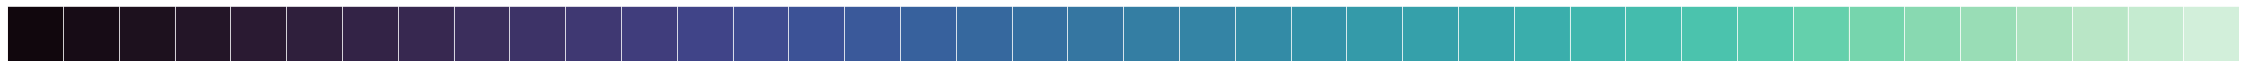

In [ ]:
current_palette = sns.color_palette('mako', 40)
sns.palplot(current_palette)

<a id="lab_func"></a>

In [ ]:
def research_train(epochs, data_tr, data_val, verbose=None):

    """
    _________________________________________________________________________________
    
    Дополнительная функция обучения. Предназначена для исследовательской части работы
    Не используется в основной - для основной части написана функция train
    Позволяет собирать историю для валидации и обучения. Сохраняет целевые метрики, 
    а также значения функции потерь
    _________________________________________________________________________________


    """

    
    history = []
    loss = [bce_loss_torch, dice_loss, focal_loss, lovasz_hinge]
    for experiment, los in enumerate(loss):
      with torch.no_grad():
        torch.cuda.empty_cache()

      loss_fn = los
      # модель Unet версии 1
      model = UNet().to(device)
      print(f'\nЭксперимент {experiment + 1}. Функция потерь {los.__name__}')


      with torch.no_grad():
        torch.cuda.empty_cache()

      opt = optim.Adam(model.parameters(), lr=1e-4)
      exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=20, gamma=0.1)



      x_val, y_val = next(iter(data_val))

      with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):

            set_global_seed(42 + epoch)
            avg_loss_train = 0
            avg_loss_val = 0

            model.train()

            for x_batch, y_batch in data_tr:
              x_batch = x_batch.to(device)
              y_batch = y_batch.to(device)

              opt.zero_grad()

              y_pred = model(x_batch).cpu()
              y_batch = y_batch.cpu()
              loss =  loss_fn(y_batch, y_pred)

              loss.backward()
              opt.step()

              avg_loss_train += loss / len(data_tr)

          

              exp_lr_scheduler.step()

            
            with torch.no_grad():
              
              inputs = x_val.to(device)
              model.eval()
              y_hat = model(inputs).cpu()
              loss_val =  loss_fn(y_val.cpu(), y_hat)
              avg_loss_val += loss_val / len(data_val)


            avg_scores_t = score_model(model, iou_pytorch, data_tr)
            avg_scores_v = score_model(model, iou_pytorch, data_val)

            pbar_outer.update(1)
            history.append((experiment + 1, los.__name__, loss, loss_val, avg_scores_t, avg_scores_v))   
            if epoch % verbose == 0 or epoch == epochs:
              print(f'epoch {epoch + 1} | train_loss {loss:.3f} | val_loss {loss_val:.3f}  | TrainIoU {avg_scores_t:.3f} | ValIoU {avg_scores_v:.3f}')
        print(f'epoch {epoch + 1} | train_loss {loss:.3f} | val_loss {loss_val:.3f}  | TrainIoU {avg_scores_t:.3f} | ValIoU {avg_scores_v:.3f}')
    return history

<a id="report"></a>

In [ ]:
def make_report(history):
   """
    _________________________________________________________________________________
    
    Дополнительная функция обучения для подготовки отчета
    _________________________________________________________________________________


    """
   experiment, loss_name, loss, loss_val, avg_scores_t, avg_scores_v = zip(*history)
   return (pd.DataFrame({ 
                        'Experiment_number': experiment,
                        'Loss_name' : loss_name ,
                        'Train_loss' : np.array(loss).astype(float),
                        'Val_loss' : np.array(loss_val),
                        'Train_IOU': avg_scores_t,
                        'Val_IOU': avg_scores_v})

            )

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Загрузка данных

Использовать будем PH2 сет:  


Дермоскопические изображения были получены в дерматологической службе больницы `Pedro Hispano` (Матозиньюш, Португалия) в тех же условиях с помощью системы `Tuebinger Mole Analyzer` с `20-кратным` увеличением. Это `8-битные` цветные изображения `RGB` с разрешением `768x560` пикселей.




1. Скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>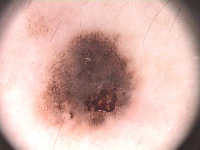</td><td>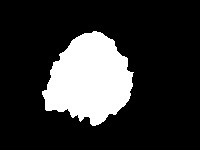</td></tr></table>

2. Разархивируем .rar файл.
3. `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
%%capture
!wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

```
25.11. ссылка стала недоступна: резерв
!gdown --id 12hcvk3yLJxrJF4HKyGrCZ3VDjE3PSTmU
```

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

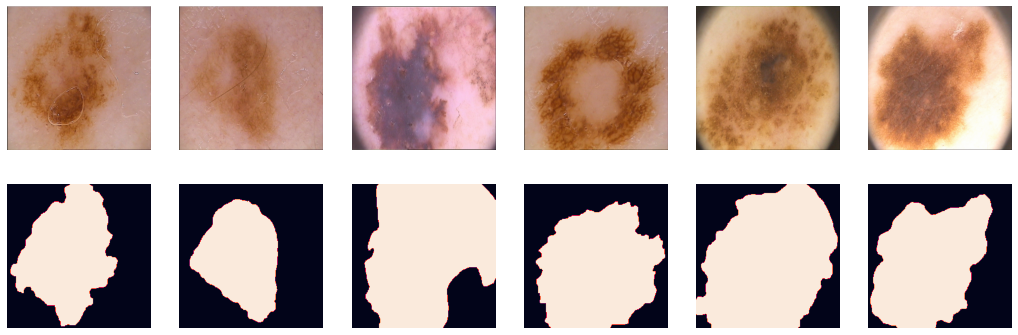

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


#### PyTorch DataLoader

In [ ]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


# Реализация различных архитектур:
Наша задача состоит в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

Создадим списки, для удобства составления сводной таблицы результатов

In [ ]:
IoU_validation = []
IoU_test = []
model_name = []
loss_name = []
train_time = []
prediction_time = []

<a id='segnet'></a>

---

## SegNet

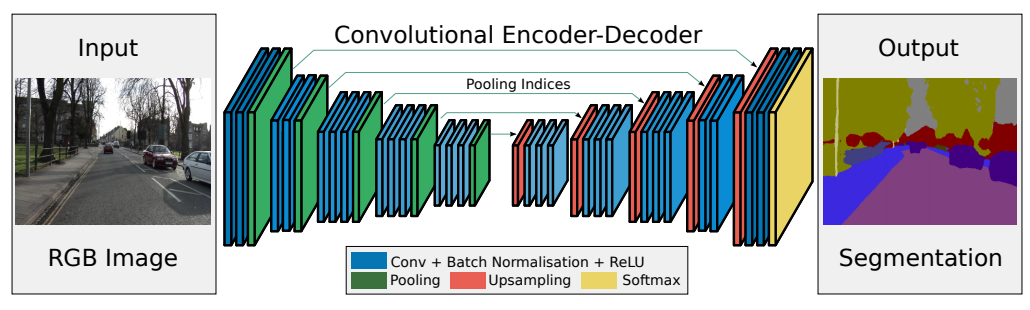

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
rcParams['figure.figsize'] = (15,4)

Построим архитектуру нашей сети - будет `5 блоков с 3 входами` (включая, `bottleneck`) на кодирование информации и `5 блоков с 1 выходом` на декодирование. На первых двух блоках и двух последних - будет два сверточных слоя с нормализацией, на `3 последних` `Downsampling` и `3 первых` `Upsampling` слоев будет 3 сверточных слоя. Количество фильтров будет возрастать от 64 до 512. Слой `MaxPool2d` будет возвращать индексы для слоев `MaxUnpool2d`

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = 3
        padding = 1
        pool = 2

        input = 3
        output = 1

        self.enc_conv0 = nn.Sequential(
            
                  nn.Conv2d(input, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv1 = nn.Sequential(
            
                  nn.Conv2d(64, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv2 = nn.Sequential(
            
                  nn.Conv2d(128, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        self.enc_conv3 = nn.Sequential(
            
                  nn.Conv2d(256, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 

       
        # bottleneck

        self.bottleneck_conv = nn.Sequential(
            


                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU()
        )        
        self.pool4 = nn.MaxPool2d(pool, stride=pool, return_indices=True) 
        # decoding
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool) 
        self.dec_conv0 =  nn.Sequential(
            
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU()
        )


        self.upsample1 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool) 
        self.dec_conv1 =  nn.Sequential(
            
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        self.upsample2 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv2 =  nn.Sequential(
            
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )
        self.upsample3 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv3 =  nn.Sequential(
            
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )
        self.upsample4 =  nn.MaxUnpool2d(kernel_size=pool, stride=pool)
        self.dec_conv4 = nn.Sequential(
            
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, output, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(output),

        )

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        x, ind0 = self.pool0(x)
        size0 = x.size()
        
        x = self.enc_conv1(x)
        x, ind1 = self.pool1(x)
        size1 = x.size()

        x = self.enc_conv2(x)
        x, ind2 = self.pool2(x)
        size2 = x.size()

        x = self.enc_conv3(x)
        x, ind3 = self.pool3(x)
        size3 = x.size()
        
        # bottleneck
        x = self.bottleneck_conv(x)
        x, ind4 = self.pool4(x)

        # decoder
        x = self.upsample0(x, ind4, output_size=size3)
        x = self.dec_conv0(x)

        x = self.upsample1(x, ind3, output_size=size2)
        x = self.dec_conv1(x)

        x = self.upsample2(x, ind2, output_size=size1)
        x = self.dec_conv2(x)

        x = self.upsample3(x, ind1, output_size=size0)
        x = self.dec_conv3(x)

        x = self.upsample4(x, ind0)
        x = self.dec_conv4(x)
        return x

In [ ]:
model = SegNet()

In [ ]:
model

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0)

Получили желаемую архитектуру нейронной сети для целей сегментации - можем переходить к испытаниям. Для начала, необходимо определиться с метрикой, на которой мы будем оценивать качество нашей модели с ипосльзованием различных функций потерь

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Метрика

Будем использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):

    outputs = outputs.squeeze(1).byte() 
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))    
    
    iou = (intersection + SMOOTH) / (union + SMOOTH) 
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  
    
    return thresholded

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Функция потерь
Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

<a id='bce'></id>

Используем другой вариант:  

$$\mathcal L_{BCE} = max (\hat y, 0) - y\hat y + \log\left(1+\exp(- |\hat y|)\right)$$


Воспользуемся упрощенным вариантом `BCE`, предложенным tensorflow - также, мы сможем использовать эту функцию при подготовке `focal loss` функции

In [ ]:
def bce_loss_torch(y_real, y_pred):
  y_pred = y_pred.view(-1)
  y_real = y_real.view(-1)
  y_pred = y_pred.type(torch.float32)
  y_real = y_real.type(torch.float32)
  
  loss = F.relu(y_pred) - y_real * y_pred + torch.log(1. + torch.exp(-abs(y_pred)))
  return torch.mean(loss)

Первая функция потерь готова - теперь подготовим функции, которые помогают обучать модель и получать оценку ее качества

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его. Добавим в нее возможность ипосльзовать шедулер и раннюю остановку

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, patience=None):
    x_val, y_val = next(iter(data_val))
    # модифицируем функцию для сохранения весов лучшей модели и patience ожидания
    # для контроля переобучения
    best_val_loss =  np.inf
    patience_count = 0
    best_model = copy.deepcopy(model.state_dict())

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
      for epoch in range(epochs):
          tic = time.time()
          print('* Epoch %d/%d' % (epoch+1, epochs))
          set_global_seed(42 + epoch)
          avg_loss = 0
          model.train()
          for x_batch, y_batch in data_tr:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            opt.zero_grad()

            y_pred = model(x_batch).cpu()
            y_batch = y_batch.cpu()
            loss =  loss_fn(y_batch, y_pred)

            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)

          toc = time.time()
          print('loss: %f' % avg_loss)
    # шаг шедулера, если указан
          if scheduler is not None:
              scheduler.step()

          pbar_outer.update(1)
    # проверка лосса
          if(best_val_loss > loss):
              patience_count = 0
              best_val_loss = loss
              best_model = copy.deepcopy(model.state_dict())
          if patience is not None:
            if(patience_count > patience):
              model.load_state_dict(best_model) 
              break
            patience_count += 1
     
          with torch.no_grad():
            
            inputs = x_val.to(device)
            model.eval()
            y_hat = model(inputs).cpu()
            clear_output(wait=True)
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(x_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(y_hat[k, 0], cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()
            

Осталось подготовить функцию для предсказаний и функция для оценки модели

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
  with torch.no_grad():
    model.eval()
    y_pred = [ x_batch for x_batch, _ in data]
  return np.array(y_pred)

In [ ]:
def score_model(model, metric, data):
    with torch.no_grad():
      model.eval() 
      scores = 0
      
      for x_batch, y_label in data:
          x_batch = x_batch.to(device)
          y_label = y_label.to(device)
          
          y_pred = torch.round(F.sigmoid(model(x_batch)))
          scores += metric(y_pred.cpu(), y_label.cpu()).mean().item()

    return scores/len(data)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### Обучение

Обучим нашу модель. Обучать необходимо до сходимости. Количество эпох поставим 40 - как на остальных лосс в дальнейшем. Ранняя остановка также будет - установим на 10 эпох, по счетчику


In [ ]:
model = SegNet().to(device)

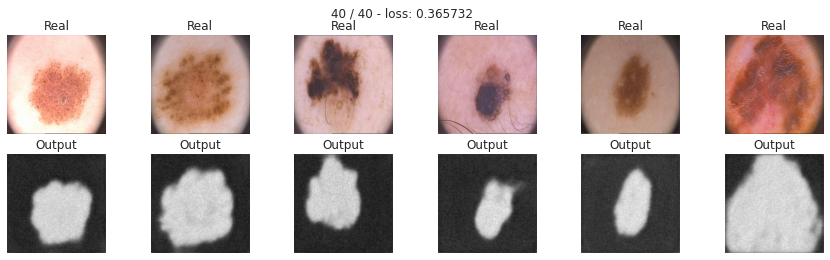

CPU times: user 2min 43s, sys: 19.8 s, total: 3min 3s
Wall time: 3min 2s


In [ ]:
%%time
start = time.time()

max_epochs = 40

opt = optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=20, gamma=0.1)

train(
      model, opt, bce_loss_torch, max_epochs, 
      data_tr, data_val, exp_lr_scheduler, 
      patience=10
      
      )

end = time.time()
elapsed = end - start

Оценим качество нашей модели на базе архитектуры `SegNet`

In [ ]:
%%time
start_pred = time.time()


score = score_model(model, iou_pytorch, data_val)

end_pred = time.time()
elapsed_pred = end_pred - start_pred

CPU times: user 474 ms, sys: 2.03 ms, total: 476 ms
Wall time: 496 ms


In [ ]:
score

0.7360000312328339

Достаточно неплохое качество - свыше 0.5 уже выглядит [неплохо](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

In [ ]:
IoU_test.append(score_model(model, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('bce_loss_torch')
train_time.append(elapsed)
prediction_time.append(elapsed_pred)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat Nov 20 10:54:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    48W / 250W |   1953MiB / 16280MiB |    100%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Вывод  


Обучили модель на 40 эпохах с целью сегментации изображений невуса. Достигли   достаточно неплохого качества на валидационной выборке. Протестируем модель с другими функциями потерь. Далее построим `Unet` архитектуру и сравним наши модели. На данный момент `SegNet` показывает неплохие результаты с `BCE loss`. Модель получает достаточно четкие контуры, волоски не попадают в результаты вывода модели



<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


---

## Дополнительные функции потерь

### Dice coefficient

 Попробуем имплементировать две функции потерь:
 `DICE` и `Focal loss`. 

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$
Также добавим сглаживание. 
___


Можно попробовать использовать [следующее упрощение](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf):  



 
$$\mathcal L_D(X,Y) = 1- \frac {\sum_i 2X_iY_i} {\sum_i X_i^2+Y_i^2}.$$



In [ ]:
def dice_loss(y_real, y_pred):

  SMOOTH = 1e-8

  y_pred = F.sigmoid(y_pred)

  y_pred = y_pred.view(-1)
  y_real = y_real.view(-1)   
  
  num = 2. * torch.sum(y_pred * y_real)
  den = torch.sum(y_pred**2) + torch.sum(y_real**2)
  res = (num) / (den + SMOOTH)

  return 1. - res

Проводим тестирование:

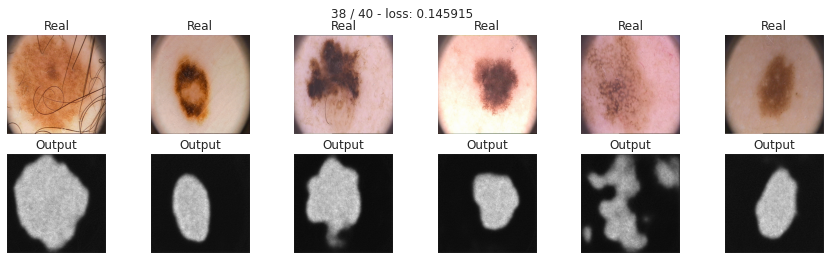

* Epoch 39/40
loss: 0.148193


In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40

optimaizer = optim.Adam(model_dice.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimaizer, step_size=20, gamma=0.1)
train(model_dice, optimaizer, dice_loss, max_epochs, 
      data_tr, data_val, exp_lr_scheduler, 
      patience=10)

In [ ]:
score = score_model(model_dice, iou_pytorch, data_val)

In [ ]:
score

0.722000002861023

In [ ]:
IoU_test.append(score_model(model_dice, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('dice_loss')

train_time.append(elapsed)
prediction_time.append(elapsed_pred)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

### Вывод  

Обучили модель на 40 эпохах с целью сегментации изображений невуса. Достигли   достаточно неплохого качества на валидационной выборке. Говорить о качестве сейчас сложно относительно других функций потерть - необходимо проводить исследования дополнительные. Модель получает достаточно четкие контуры, волоски не попадают в результаты вывода модели. И оценка на валидации достаточно высокая. Взяли [иное](http://far.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf) упрощение `Dice loss`, потому что в противном случае у нас слишком разнится масштаб значений лосс функций

### Focal loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


$$\mathcal L_{focal}(p_t) = - \alpha (1 - p_t)^\gamma\log(p_t) $$

По сути, это cross entropy с коэффициентом. При этом, если γ = 0 - focal loss будет вести себя как обычная CE. pt можно представить в виде такого выражения:  

```
torch.where(y_real == 1, y_pred, 1 - y_pred)
```
Мы будем находить `pt` как `torch.exp( - BCE )`, а [BCE](#bce) найдем с помощью ранее подготовленной функции. Таким образом, получим, что наш `focal loss` будет основываться на ранее написанной функции. Стоит отметить, что также добавили α коэффициент - с ним получили лучше результаты


In [ ]:
def focal_loss(y_real, y_pred):

    GAMMA = 2
    ALPHA = .8
    y_pred = y_pred.type(torch.float32)
    y_real = y_real.type(torch.float32)

    BCE = bce_loss_torch(y_real, y_pred)
    pt = torch.exp(-BCE)
    focal_loss = ALPHA * (1. - pt)**GAMMA * BCE

    return focal_loss

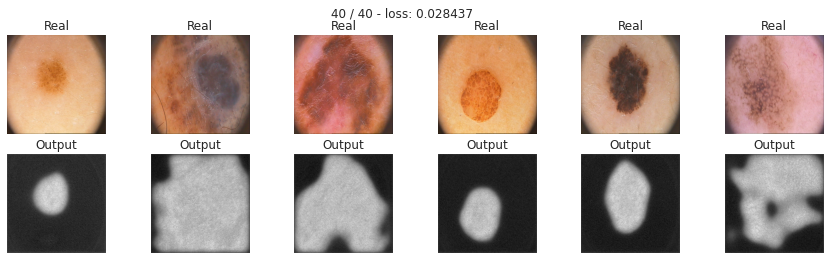

CPU times: user 2min 43s, sys: 20 s, total: 3min 3s
Wall time: 3min 3s


In [ ]:
%%time
model_focal = SegNet().to(device)


start = time.time()
max_epochs = 40
optimaizer = optim.Adam(model_focal.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimaizer, step_size=20, gamma=0.1)
train(model_focal, optimaizer, focal_loss, max_epochs, 
      data_tr, data_val, exp_lr_scheduler, 
      patience=10)

end = time.time()
elapsed = end - start

In [ ]:
%%time
start_pred = time.time()

score = score_model(model_focal, iou_pytorch, data_val)

end_pred = time.time()
elapsed_pred = end_pred - start_pred

CPU times: user 487 ms, sys: 1.86 ms, total: 489 ms
Wall time: 495 ms


In [ ]:
score

0.7019999921321869

In [ ]:
IoU_test.append(score_model(model_focal, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('focal_loss')
train_time.append(elapsed)
prediction_time.append(elapsed_pred)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

### Вывод  


Обучили модель на 40 эпохах с целью сегментации изображений невуса, аналогично тому, что мы делали уже выше. Достигли  достаточно неплохого качества на валидационной выборке - проведем в дальнейшем еще тесты и определимся с лучшей лосс для данной задачи. Модель получает достаточно четкие контуры, волоски не попадают в результаты вывода модели. И оценка на валидации достаточно высокая. `Focal loss` сделали на базе нашей функции `BCE` - по сути это развитие и улучшение `cross-entropy`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


---

## The Lovasz-Hinge loss

Напишем еще одну функцию потерь. Также, проведем численное сравнение с предыдущими функциями.

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

___

Попробуем реализовать [`The Lovasz-Hinge loss`](https://hal.inria.fr/hal-01241626v1/document) (вариант оптимизации [коэффициента Жаккарда](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0) по алгоритму, основанному на отсортированных ошибках.) 

Оптимизация выглядит следующим образом:

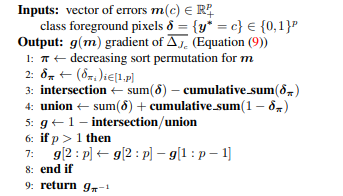


Для того, чтобы найти ошибки мы для начала находим сигнум ошибки:
вектор положительный, когда прогнозы ложные, и отрицательный, когда прогнозы верны. Однако, правильные прогнозы с запасом ниже - 1 также считаются ошибкой.


Затем мы сортируем список ошибок и находим индексы, по которым отбираем значения для вектора `grad`.


Вектор `grad` - `g` содержит "эволюцию" индекса Жаккара по отношению к отсортированным ошибкам. Он варьируется от 0 до фактического индекса Жаккара прогноза. На последнем этапе, loss вычисляется как скалярное произведение между вектором ошибки и градиентом расширения. Мы используем Relu, потому что нас интересует только положительная часть вектора ошибок.

In [ ]:
# https://arxiv.org/pdf/1705.08790.pdf
def grad_lovasz(sorted_errors):

    err_cumm = sorted_errors.float().cumsum(0)
    opp_err_cumm = (1 - sorted_errors).float().cumsum(0)
    p = len(sorted_errors)
    err = sorted_errors.sum()
    intersection = err - err_cumm
    union = err + opp_err_cumm
    grad = 1 - intersection / union
    if p > 1:
      grad[1:p] = grad[1:p] - grad[0:p-1]
    return grad


# https://arxiv.org/pdf/1512.07797.pdf. 
def lovasz_hinge(y_real, y_pred):

    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)
    sgn = 2 * y_real.float() - 1
    errs = (1 - y_pred * torch.tensor(sgn, requires_grad=True))
    sorted_errors, indices = torch.sort(errs, dim=0, descending=True)
    indices = indices.data
    errs_for_grad = y_real[indices]
    grad = grad_lovasz(errs_for_grad)
    loss = torch.dot(F.relu(sorted_errors), torch.tensor(grad, requires_grad=True))
    return loss

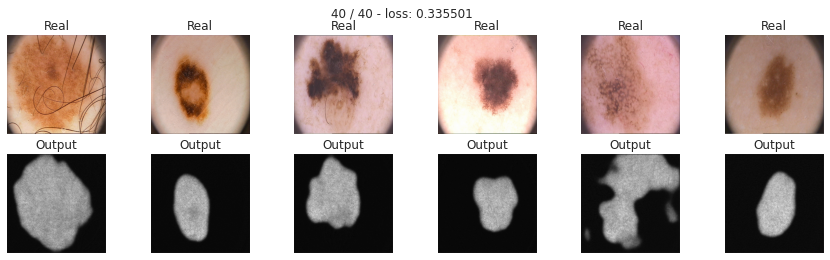

CPU times: user 3min 17s, sys: 19.7 s, total: 3min 37s
Wall time: 3min 36s


In [ ]:
%%time
model_lovasz = SegNet().to(device)

start = time.time()

max_epochs = 40
optimaizer = optim.Adam(model_lovasz.parameters(), lr=1e-4)
exp_lr_scheduler = lr_scheduler.StepLR(optimaizer, step_size=20, gamma=0.1)
train(model_lovasz, optimaizer, lovasz_hinge, max_epochs, 
      data_tr, data_val, exp_lr_scheduler,
      patience=10)

end = time.time()
elapsed = end - start

In [ ]:
%%time
start_pred = time.time()

score = score_model(model_lovasz, iou_pytorch, data_val)

end_pred = time.time()
elapsed_pred = end_pred - start_pred

CPU times: user 488 ms, sys: 3.46 ms, total: 492 ms
Wall time: 493 ms


In [ ]:
score

0.7179999947547913

In [ ]:
IoU_test.append(score_model(model_lovasz, iou_pytorch, data_ts))
IoU_validation.append(score)
model_name.append('SegNeT')
loss_name.append('lovasz_hinge')
train_time.append(elapsed)
prediction_time.append(elapsed_pred)

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Sat Nov 20 11:04:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    49W / 250W |   3945MiB / 16280MiB |     89%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Вывод  


Обучили модель на 40 эпохах с целью сегментации изображений невуса, аналогично тому, что мы делали уже выше. Модель получает достаточно четкие контуры, волоски искажают  результаты вывода модели. И оценка на валидации достаточно высокая. Попробовали реализовать лосс-функцию на основе вектора Жаккарда. 

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


Посмотрим промежуточный отчет

In [ ]:
summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test }
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet')
)

In [ ]:
summary

Очень хорошие результаты получаем с лосс, работающим с пересечением. Перейдем к `U-net` - построим ее архитектуру. Затем проведем непосредственно обучение и оценку на различных loss, по аналогии с `SegNet`

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


---
##  U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментаци, но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

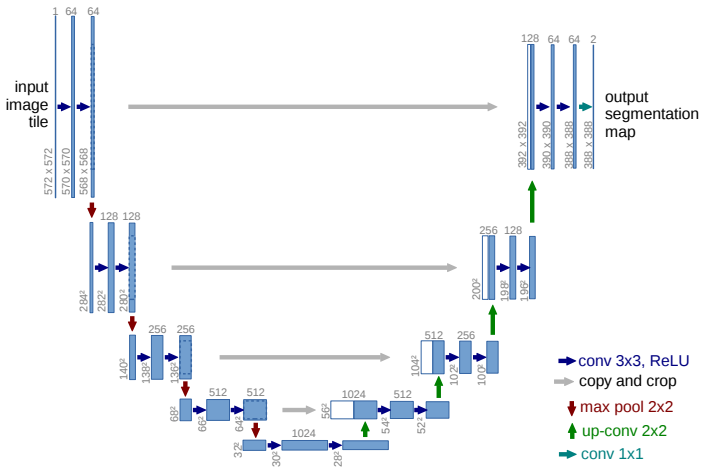

В архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особенностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

### U-Net базовая UpsamplingNearest2d

Составим архитектуру сети на базе классов `MaxPool2d` и `UpsamplingNearest2d`

<a id='unet1'></a>

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        kernel = 3
        padding = 1
        pool = 2
        input = 3
        output = 1

        # encoder (downsampling)

        self.down_1 =  nn.Sequential(
            
                  nn.Conv2d(input, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(pool, stride=pool)

        self.down_2 =  nn.Sequential(
            
                  nn.Conv2d(64, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU(),
                  nn.Conv2d(128, 128, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(128),
                  nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(pool, stride=pool)

        self.down_3 =  nn.Sequential(
            
                  nn.Conv2d(128, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU(),
                  nn.Conv2d(256, 256, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(256),
                  nn.ReLU()
        )
        
        self.pool3 = nn.MaxPool2d(pool, stride=pool)
        self.down_4 =  nn.Sequential (
            
                  nn.Conv2d(256, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
        )
        self.pool4 = nn.MaxPool2d(pool, stride=pool)
       

        # bottleneck

        self.bottleneck_conv = nn.Sequential(
            


                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),
                  nn.Conv2d(512, 512, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(512),
                  nn.ReLU(),

        )        
        
        # decoder (upsampling)

        self.upsample0 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv0 =  nn.Sequential(
            
                      nn.Conv2d(1024, 512, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(512),
                      nn.ReLU(),
                      nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
        )

        self.upsample1 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv1 =  nn.Sequential(
            
                      nn.Conv2d(512, 256, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(256),
                      nn.ReLU(),
                      nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
        )

        self.upsample2 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv2 =  nn.Sequential(
            
                      nn.Conv2d(256, 128, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(128),
                      nn.ReLU(),
                      nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                      nn.BatchNorm2d(64),
                      nn.ReLU(),
        )
 
        self.upsample3 =  nn.UpsamplingNearest2d(scale_factor=2)
        self.dec_conv3 =  nn.Sequential(
            
                  nn.Conv2d(128, 64, kernel_size=kernel, padding=padding),
                  nn.BatchNorm2d(64),
                  nn.ReLU(),
                  nn.Conv2d(64, output, kernel_size=1),
                  nn.BatchNorm2d(output)

        )


                   

    def forward(self, x):
        # encoder (downsampling)
        out_1 = self.down_1(x)
        out_pool_1 = self.pool1(out_1)

        out_2 = self.down_2(out_pool_1)
        out_pool_2 = self.pool2(out_2)

        out_3 = self.down_3(out_pool_2)
        out_pool_3 = self.pool3(out_3)

        out_4 = self.down_4(out_pool_3)
        out_pool_4 = self.pool4(out_4)

        # bottleneck

        bottleneck = self.bottleneck_conv(out_pool_4)

        # decoder (upsampling)
        up_1 = self.upsample0(bottleneck)
        up_out_1 = torch.cat((up_1, out_4), dim=1)
        out_5 = self.dec_conv0(up_out_1)


        up_2 = self.upsample1(out_5)
        up_out_2 = torch.cat((up_2, out_3), dim=1)
        out_6 = self.dec_conv1(up_out_2)

        up_3 = self.upsample2(out_6)
        up_out_3 = torch.cat((up_3, out_2), dim=1)
        out_7 = self.dec_conv2(up_out_3)

        up_4 = self.upsample3(out_7)
        up_out_4 = torch.cat((up_4, out_1), dim=1)
        preds = self.dec_conv3(up_out_4)
        return preds

Протестируем нашу модель на всех лоссах, что мы исследовали на `SegNet` - данные соберем в сводную таблицу и посмотрим в сравнении. Отдельно обучать сейчас не будем - если модель покажет себя по совокупности характеристик лучше, чем `SegNet` - мы будем тестировать лосс функции отдельно и решим - какую комбинацию модели и функции использовать для данной задачи

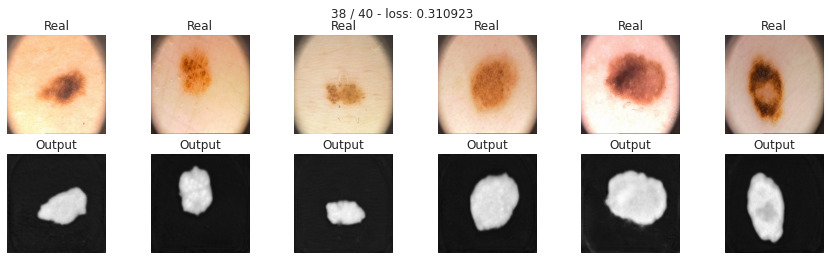

* Epoch 39/40
loss: 0.318753
CPU times: user 12min 11s, sys: 5.18 s, total: 12min 16s
Wall time: 12min 14s


In [ ]:
%%time
loss = [bce_loss_torch, dice_loss, focal_loss, lovasz_hinge]

IoU_validation_self = []
IoU_test_self = []
model_name_self = []
loss_name_self = []
train_time_self = []
prediction_time_self = []



for los in loss:
  print(f'Обучение модели U-Net на {los.__name__}')

  with torch.no_grad():
    torch.cuda.empty_cache()
  start = time.time()
  unet_model = UNet().to(device)
  max_epochs = 40

  opt = optim.Adam(unet_model.parameters(), lr=1e-4)
  exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=20, gamma=0.1)

  train(
        unet_model, opt, los, max_epochs, 
        data_tr, data_val, exp_lr_scheduler, 
        patience=10
        
        )
  end = time.time()
  elapsed = end - start
  IoU_test.append(score_model(unet_model, iou_pytorch, data_ts))
  start_pred = time.time()
  IoU_validation.append(score_model(unet_model, iou_pytorch, data_val))
  end_pred = time.time()
  elapsed_pred = end_pred - start_pred
  model_name.append('U-Net UpsamplingNearest2d')
  loss_name.append(f'{los.__name__}')
  train_time.append(elapsed)
  prediction_time.append(elapsed_pred)

  #отдельный отчет на данный этап для удобства

  IoU_test_self.append(score_model(unet_model, iou_pytorch, data_ts))
  IoU_validation_self.append(score_model(unet_model, iou_pytorch, data_val))
  model_name_self.append('U-Net UpsamplingNearest2d')
  loss_name_self.append(f'{los.__name__}')
  train_time_self.append(elapsed)
  prediction_time_self.append(elapsed_pred)




  with torch.no_grad():
    torch.cuda.empty_cache()


  

  report = (pd.DataFrame({ 
    'Model' : model_name_self , 
    'Loss' : loss_name_self ,
    'IoU_validation' : IoU_validation_self ,
    'IoU_test' : IoU_test_self,
    'Train_time': train_time_self,
    'Prediction time': prediction_time_self}
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .assign(
        
        val_test_diff = lambda x: abs(1 - x['IoU_test'] / x['IoU_validation']) * 100
    )
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .highlight_max( 'IoU_validation' , color = 'grey' , axis = 0 )
    .highlight_min( 'val_test_diff' , color = 'blue' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet и U-Net')
    .hide_index()
)
  
  

In [ ]:
report

Время предсказания у модели в комбинации со всеми Loss функциями примерно равно. Обучение быстрее всего проходит на `dice_loss`, при этом и качество достаточно хорошее. Поскольку, нам не критично время обучения - то на него можно не ориентироваться - ведь работать будет уже обученная модель, в случае вывода в продакшн. Но стоит отметить, что с `bce_loss` модель лучше обобщается. А функции потерь связанные с пересечением и объединением предсказаний дают хорошие результаты

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


### U-Net с ConvTranspose2d

<a id='unet2'></a>

Составим новую архитектуру сети, заменив пулинги для `DownSampling` и `Up-sampling`. Воспользуемся модулем `ConvTranspose2d` [дополнительно](https://www.matthewzeiler.com/mattzeiler/deconvolutionalnetworks.pdf) **(transpose_convolution)** - выставим `stride 2` и для downsampling изменим параметры `MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)` на `nn.MaxPool2d(3, 2, padding=1)`

Для удобства, попробуем сократить наш код, использую функции для формирования слоев сети

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.down_1 = self.downsampling_(3, 64)
        self.down_2 = self.downsampling_(64, 128)
        self.down_3 = self.downsampling_(128, 256)
        self.down_4_bottle = self.bottleneck_conv(256, 512)

        self.upsample1 = self.upsampling_(512, 256)
        self.upsample2 = self.upsampling_(256, 128)
        self.upsample3 = self.upsampling_(128, 64)

        self.preds = nn.Sequential(
            nn.ConvTranspose2d(
                64, 1, kernel_size=3, padding=1, stride=2, output_padding=1
            )
        )

    def downsampling_(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )


    def bottleneck_conv(self, in_chan, out_chan):
        return nn.Sequential(
            nn.Conv2d(in_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU(),
            nn.Conv2d(out_chan, out_chan, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_chan),
            nn.ReLU()

        )       
  

    def upsampling_(self, in_chan, out_chan):
        return nn.ModuleList(
            [
                nn.ConvTranspose2d(in_chan, out_chan, kernel_size=3,
                                   stride=2, padding=1, output_padding=1),
              # обязательно задать на первый модуль output_padding - определяет форму вывода
                nn.BatchNorm2d(2 * out_chan),
                nn.ReLU(),
                nn.ConvTranspose2d(2 * out_chan, out_chan, kernel_size=3,
                                   stride=1, padding=1),
              # обязательно задать stride = 1, вместо 2 - иначе на вход следующему слою придет меньше фильтров
                nn.BatchNorm2d(out_chan),
                nn.ReLU(),
            ]
        )

    def forward(self, x):
        out_1 = self.down_1(x)
        out_2 = self.down_2(out_1)
        out_3 = self.down_3(out_2)
        out_4 = self.down_4_bottle(out_3)


        up_out_1 = self.upsample1[0](out_4)
        up_out_1 = torch.cat([out_3, up_out_1], dim=1)
        for out_ in self.upsample1[1:]:
            up_out_1 = out_(up_out_1)

        up_out_2 = self.upsample2[0](up_out_1)
        up_out_2 = torch.cat([out_2, up_out_2], dim=1)
        for out_ in self.upsample2[1:]:
            up_out_2 = out_(up_out_2)

        up_out_3 = self.upsample3[0](up_out_2)
        up_out_3 = torch.cat([out_1, up_out_3], dim=1)
        for out_ in self.upsample3[1:]:
            up_out_3 = out_(up_out_3)
     

        preds = self.preds(up_out_3)
        return preds

Аналогично, протестируем все лоссы. Соберем данные для анализа. Дальше сможем оценить производительность по совокупности харктеристик

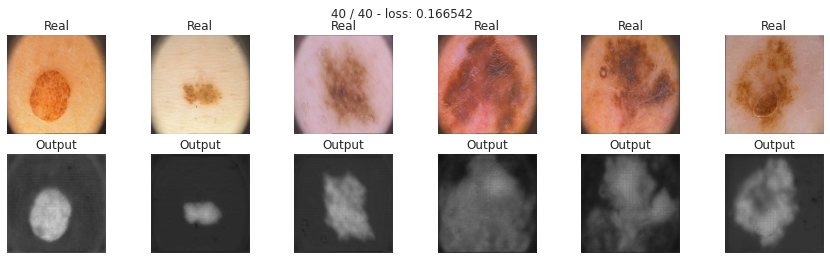

CPU times: user 10min 1s, sys: 6.54 s, total: 10min 7s
Wall time: 10min 4s


In [ ]:
%%time
loss = [bce_loss_torch, dice_loss, focal_loss, lovasz_hinge]

IoU_validation_self = []
IoU_test_self = []
model_name_self = []
loss_name_self = []
train_time_self = []
prediction_time_self = []



for los in loss:
  print(f'Обучение модели U-Net на {los.__name__}')

  with torch.no_grad():
    torch.cuda.empty_cache()
  start = time.time()
  unet2_model = UNet2().to(device)
  max_epochs = 40

  opt = optim.Adam(unet2_model.parameters(), lr=1e-4)
  exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=20, gamma=0.1)

  train(
        unet2_model, opt, los, max_epochs, 
        data_tr, data_val, exp_lr_scheduler, 
        patience=10
        
        )
  end = time.time()
  elapsed = end - start
  IoU_test.append(score_model(unet2_model, iou_pytorch, data_ts))
  start_pred = time.time()
  IoU_validation.append(score_model(unet2_model, iou_pytorch, data_val))
  end_pred = time.time()
  elapsed_pred = end_pred - start_pred
  model_name.append('U-Net ConvTranspose2d')
  loss_name.append(f'{los.__name__}')
  train_time.append(elapsed)
  prediction_time.append(elapsed_pred)

  #отдельный отчет на данный этап для удобства

  IoU_test_self.append(score_model(unet2_model, iou_pytorch, data_ts))
  IoU_validation_self.append(score_model(unet2_model, iou_pytorch, data_val))
  model_name_self.append('U-Net ConvTranspose2d')
  loss_name_self.append(f'{los.__name__}')
  train_time_self.append(elapsed)
  prediction_time_self.append(elapsed_pred)




  with torch.no_grad():
    torch.cuda.empty_cache()


  

  report_ct = (pd.DataFrame({ 
    'Model' : model_name_self , 
    'Loss' : loss_name_self ,
    'IoU_validation' : IoU_validation_self ,
    'IoU_test' : IoU_test_self,
    'Train_time': train_time_self,
    'Prediction time': prediction_time_self}
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .assign(
        
        val_test_diff = lambda x: abs(1 - x['IoU_test'] / x['IoU_validation']) * 100
    )
    .style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .highlight_max( 'IoU_validation' , color = 'grey' , axis = 0 )
    .highlight_min( 'val_test_diff' , color = 'blue' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet и U-Net')
    .hide_index()
)
  
  

In [ ]:
report_ct

Время предсказания у модели в комбинации со всеми Loss функциями примерно равно и выше, чем у `U-net UpsamplingNearest2D`. Обучение быстрее всего проходит на `focal_loss`, при этом и качество достаточно хорошее - разница не такая значительная и может быть связана с различными случайными факторами. Если брать более сложный `loss`, например `lovasz hinge` - то время обучения растет. По скольку, нам не критично время обучения - то на него можно не ориентироваться - ведь работать будет уже обученная модель, в случае вывода в продакшн. Стоит обратить внимание, что данная архитектуру более точно передает структуру исследуемого новуса

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


Соберем итоговый отчет 

In [ ]:
summary = (pd.DataFrame({ 
    'Model' : model_name , 
    'Loss' : loss_name ,
    'IoU_validation' : IoU_validation ,
    'IoU_test' : IoU_test,
    'Train_time': train_time,
    'Prediction_time': prediction_time}
    ).sort_values(by='IoU_test', ascending=False)
    .reset_index(drop=True)
    .assign(
        
        val_test_diff = lambda x: abs(1 - x['IoU_test'] / x['IoU_validation']) * 100
    )
    
)

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


# Отчёт

___

## Резюме

Провели исследования различных архитекту нейронных сетей для задачи семантической сегментации. Удалось построить архитектуру подобную `SegNet` на базе `MaxPool2d` и `MaxUnpool2d`, удалось построить архитектуру сети `U-Net` с помощью `MaxPool2d` и `UpsamplingNearest2d`, удалось построить архитектуру сети `U-Net` с помощью `MaxPool2d` и `ConvTranspose2d`.

Наибольшие трудности возникли с построением `U-net` из-за операции конкатенации, заложенной в суть архитектуры данной сети. Модули `ConvTranspoe2d` - также потребовали достаточно внимания при проработке. Удалось сократить количество кода, путем добавления функций на создания слоев нейронной сети

Мы реализовали 4 функции потерь:

1. $\mathcal L_{BCE} = max (\hat y, 0) - y\hat y + \log\left(1+\exp(- |\hat y|)\right)$ - BCE Loss, использовали упрощение с защитой от переполнения, поэтому обновили функцию, добавив $ReLu$ на $\hat y$ в начале и $|\hat y|$
2. $\mathcal L_D(X,Y) = 1- \frac {\sum_i 2X_iY_i} {\sum_i X_i^2+Y_i^2}$ - DICE loss  в таком исполнении. Мы отказались от упрощения с коэффциентом $\frac{1}{256 \times 256}$ (в таком случае loss принимает достаточно низкие значения и выражение 1 - DICE изменяется не так заметно. Для удобства приняли иное упрощение ($\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}$))
3. $\mathcal L_{focal}(y, \hat y) = -\sum_i \alpha \left[\left  (1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right]$ - Focal loss, ни что иное как CE с коэффициентомю Также испльзовали α-коэффициент. Смогли реализовать через готовую функцию, сделанную в п.1 BCE loss. Развили идею BCE
4. [The Lovasz-Hinge loss](https://hal.inria.fr/hal-01241626v1/document) (вариант оптимизации [коэффициента Жаккарда](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0) по алгоритму, основанному на отсортированных ошибках)

___

На некоторых экспериментах удалось достичь значений метрики `IoU 0.77+`

In [ ]:
(summary.style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .highlight_max( 'IoU_validation' , color = 'grey' , axis = 0 )
    .highlight_min( 'val_test_diff' , color = 'blue' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet и U-Net')
    .hide_index()
    )

___

Ниже результаты работы архитектур с `lovasz_hinge`

1. Результаты `Unet с UpsamplingNearest2d`

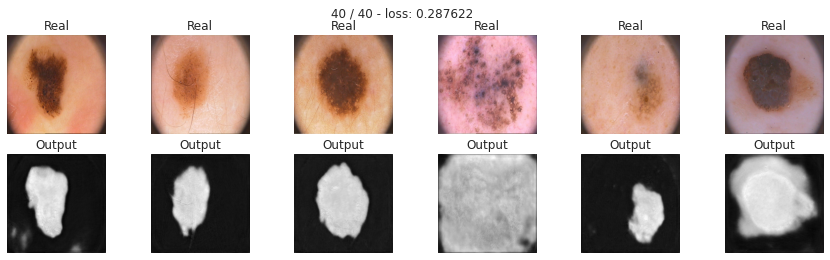

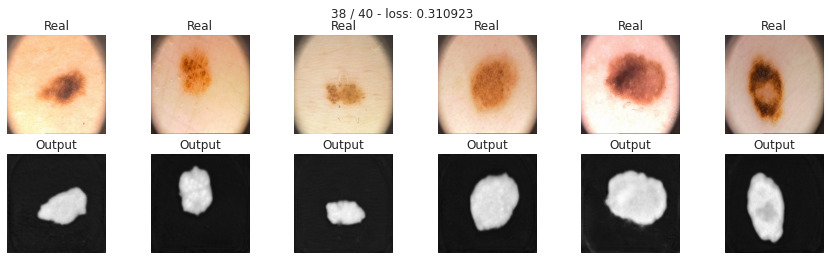

Хорошие контуры, есть незначительные ошибки. Волоски не попали в выход модели. На изображениях можно заметить структуру невуса

2. Результаты `Unet с ConvTransposed2d`

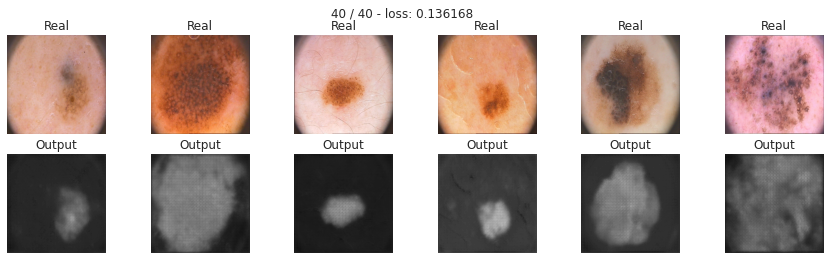

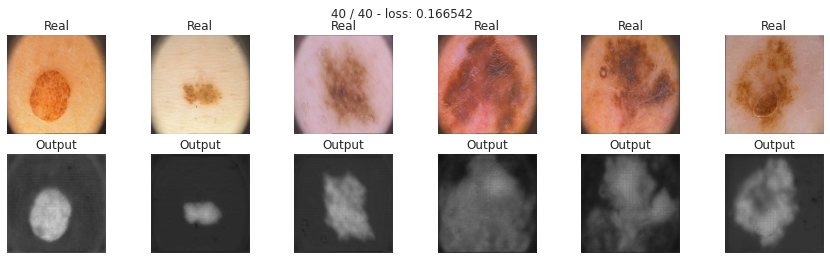

Менее четкое изображение, но при этом ярко выражена структура и больше внимания к деталям контура - больше напоминает фотографию, чем другие модели

3. Результаты `SegNet`

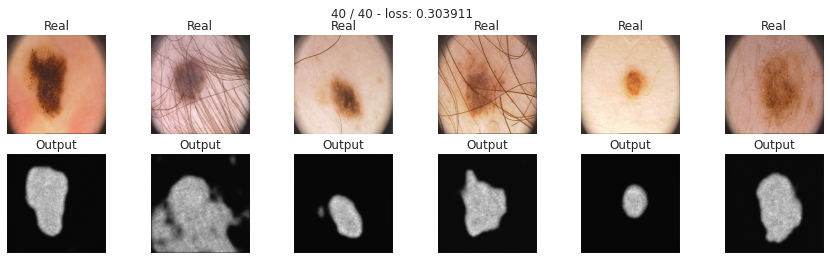

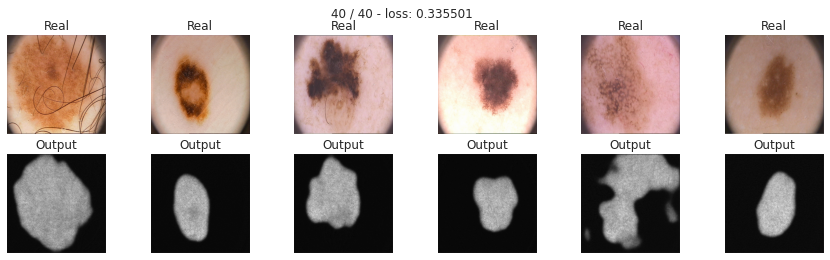

Здесь уже волоски попадают в сегментацию, но IoU достаточно высокий. Но можно видеть, как смещаются формы из-за волос

___

Мы провели исследования и пришли к следующим выводам:

- лучшая модель для сегментации изображений невуса - Архитектура на базе `U-Net с UpsamplingNearest2d` модулями. Дает меньше ошибок, более аккуратная к контурам. Но само по себе, архитектура влияет на ошибку не так сильно, как выбранный `loss`. В целом, если важно время предсказаний - выбор стоит оставновить на `U-net ConvTransposed2d`. Назовем это trade-off времени отклика и качества

- однозначно, стоит подбирать функцию для задачи сегментации под доменную область своих данных. Функции потерь оказывают сильное влияние на производительность сети. Например, `U-Net UpsamplingNearest2d с bce_loss_torch` показывает результаты хуже, чем `SegNeT с lovasz_hinge`. Но стоит использовать функцию потерь `lovasz_hinge` - и мы получаем значительный прирост к метрике

- лучшая функция потерь - `lovasz_hinge`, основанная на отсортированных ошибках. Работает с пересечениями и объединениями областей

---

 <font size="1"> Ниже представлены подходы к исследованию качества модели и обоснования. Резюме - краткое содержание </font>

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>


## Исследование

Меланома (лат. `melanoma, melanoma malignum` от др.-греч. μέλας — «чёрный» + -ομα «опухоль», уст. меланобластома) — злокачественная опухоль, развивающаяся из меланоцитов — пигментных клеток, продуцирующих меланины. Наряду с плоскоклеточным и базальноклеточным раком кожи относится к злокачественным опухолям кожи. Преимущественно локализуется в коже, реже — сетчатке глаза, слизистых оболочках (полость рта, влагалище, прямая кишка). Одна из наиболее опасных злокачественных опухолей человека, часто рецидивирующая и метастазирующая лимфогенным и гематогенным путём почти во все органы. Особенностью является слабая ответная реакция организма или её отсутствие, из-за чего меланома зачастую стремительно прогрессирует. [источник](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%BB%D0%B0%D0%BD%D0%BE%D0%BC%D0%B0)  

В настоящее время, познания в области компьютерного зрения и Deep learning, в целом, а также развитию медицины и понимания биологии опухоли, приводят к разработке новых подходов для выявления данного заболевания. 


Мы работали с дермоскопическими изображениями, которые были получены в дерматологической службе больницы Pedro Hispano (Матозиньюш, Португалия). Целью работы на данном этапе - проработать механизм сегментации невуса, рассмотреть различные архитектуры нейронных сетей для целей сегментации и оценить их работу.   





В рамках данного эксперимента мы попытались найти ответы на следующие локальные вопросы:

1. Какая модель лучше справится с сегментацией изображений невуса? Какую аръитектуру сети необходимо зафиксировать для данной задачи?  
2. Действительно ли лучший результат будет получать с функциями на основе IoU? 
3. Стоит ли заниматься подбором функции потерь для задач сегмнетации изображений или полученный прирост в качестве будет незначительным, и работать надо в направлении развития и улучшения архитектуры нейронных сетей


В ходе исследования мы имплементировали 3 архитектуры нейронных сетей для целей сегментации:   

- [SegNet](#segnet); 
- [U-Net базовая UpsamplingNearest2d](#unet1);
- [U-Net с ConvTranspose2d](#unet2)

Данные из 200 изображений были разделены в следующей пропорции: `100/50/50` для обучения, валидации и теста, соответственно. Из предобработки применяли только resize и приведение размеров изображения к единому - `256 x 256`

Мы провели их обучение на различных функциях потерь и оценили качество на метрике `Intersection over Union`. Ниже приведены результаты тестировния архитектур моделей. 

In [ ]:
(summary.style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .highlight_max( 'IoU_validation' , color = 'grey' , axis = 0 )
    .highlight_min( 'val_test_diff' , color = 'blue' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet и U-Net')
    .hide_index()
    )

Для задач сегментации изображений, зачастую применяются loss функции, основанные на оценке совпадения распознанных зон. Казалось бы, что интуитивно, такие функции дают лучшие результаты, нежеле те, что не предназначались изначально для изображений, например кросс-энтропийные. Исследуем полученные результаты и определимся с лучшей архитектурой нейронной сети, которую зафикисируем и провдем дополнительные исследования на предмет поведения на этапе обучения и результирующие значения целевой метрики

Для начала, посмотрим какие результаты на обучении и тестировании `в среднем` дают модели на разных `loss`. Это позволит примерно оценить качество модели и немного нивелировать влияение случайных факторов

In [ ]:
rep_1 = summary.groupby('Model')[['IoU_validation', 'IoU_test']].agg('mean')

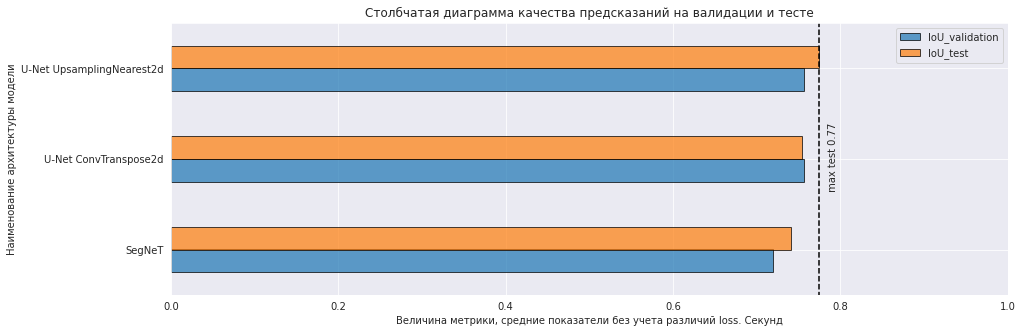

In [ ]:
rep_1.plot(kind='barh', figsize=(15,5), ec='black', alpha=.71)
max_ = rep_1['IoU_test'].max()
plt.vlines(x=max_, ymin=-10, ymax=100, linestyle='--')
plt.text(max_ + 0.01, 1, f' max test {max_:.2f}', rotation=90, va='center')
plt.xlim(left=0, right=1)
plt.title('Столбчатая диаграмма качества предсказаний на валидации и тесте')
plt.xlabel('Величина метрики, средние показатели без учета различий loss. Секунд')
plt.ylabel('Наименование архитектуры модели')
plt.show()

В среднем, модели показывают одинаковое поведение - но архитектуры `U-net` показывают более точные результаты по метрике `IoU`. Лучше всех себя тут показывает архитектура `U-Net UpsamplingNearest2d`

Оценим время обучения - что характеризует, зачастую, и обуславливает сложностью модели при одинаковых входных данных. Но опять же, нам время обучения не так критично в целом. Важнее получать быстрее предсказания

In [ ]:
rep_2 = summary.groupby('Model', as_index=False)['Prediction_time'].agg('mean')

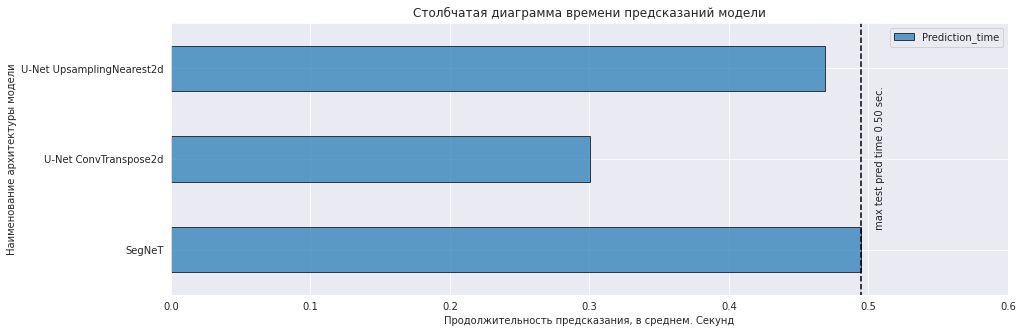

In [ ]:
max_ = rep_2['Prediction_time'].max()
rep_2.set_index('Model').plot(kind='barh', figsize=(15,5), ec='black', alpha=.71)
plt.vlines(x=max_, ymin=-10, ymax=100, linestyle='--')
plt.text(max_ + 0.01, 1, f' max test pred time {max_:.2f} sec.', rotation=90, va='center')
plt.xlim(left=0, right=0.6)
plt.title('Столбчатая диаграмма времени предсказаний модели')
plt.xlabel('Продолжительность предсказания, в среднем. Секунд')
plt.ylabel('Наименование архитектуры модели')
plt.show()

Мы видим, что быстрее всех предсказывает модель с архитектурой `U-Net ConvTranspose2d`. Между двумя архитектурами `U-net` необходимо выбирать в совокупности цена\время. Считаем, что `0.15 секунд`, не стоит потери качества

Посмотрим теперь время обучения моделей

In [ ]:
rep_3 = summary.groupby('Model', as_index=False)['Train_time'].agg('mean')

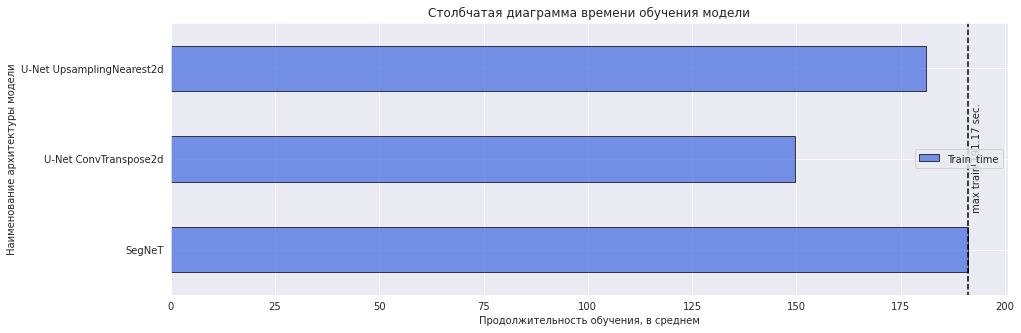

In [ ]:
max_ = rep_3['Train_time'].max()
rep_3.set_index('Model').plot(kind='barh', figsize=(15,5), 
                              ec='black', alpha=.71, color='royalblue')
plt.vlines(x=max_, ymin=-10, ymax=100, linestyle='--')
plt.text(max_ + 1, 1, f' max train {max_:.2f} sec.', rotation=90, va='center')

plt.title('Столбчатая диаграмма времени обучения модели')
plt.xlabel('Продолжительность обучения, в среднем')
plt.ylabel('Наименование архитектуры модели')
plt.show()

В среднем, дольше всех обучается архитектура на базе `SegNet`, что может быть связано с необходимость сохранения индексов и дополнительными рассчетами положения пикселя на этапе upsampling, так или иначе, в среднем - быстрее учатся модели `U-Net`. Но повторюсь, речь идет о среднем значении. Мы видили, что при различных loss модель ведет себя по разному

Таким образом, если рассматривать результаты в среднем - выигрывает архитектура на базе `U-Net с UpsamplingNearest2d`, но стоит обратить внимание, что качество моделей в среднем приблизительно равно - это косвенно свидетельствует о том, что немалое влияние на производительность оказывает выбранная функция потерь. И если нам важно время предсказаний - выбор стоит оставноить на   `U-Net с ConvTranspose2d`. мы продолжим исследование с упором на качество и возьмем `UpsamplingNearest2d`


Зафиксируем архитектуру `U-Net с UpsamplingNearest2d` как лучшую для нашей задачи в плане метрики и займемся анализом функций потерь на базе этой архитектуры

Для анализа функий потерь и их влияния на выход модели - будем обучать модель 3 раза на одном лосс и смотреть статистики качества на валидационной выборке и обучении, а также тесте при разных лосс

___

Напомню, что мы реализовали 4 функции потерь:

1. $\mathcal L_{BCE} = max (\hat y, 0) - y\hat y + \log\left(1+\exp(- |\hat y|)\right)$ - BCE Loss, использовали упрощение с защитой от переполнения, поэтому обновили функцию, добавив $ReLu$ на $\hat y$ в начале и $|\hat y|$
2. $\mathcal L_D(X,Y) = 1- \frac {\sum_i 2X_iY_i} {\sum_i X_i^2+Y_i^2}$ - DICE loss  в таком исполнении. Мы отказались от упрощения с коэффциентом $\frac{1}{256 \times 256}$ (в таком случае loss принимает достаточно низкие значения и выражение 1 - DICE изменяется не так заметно. Для удобства приняли иное упрощение ($\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}$))
3. $\mathcal L_{focal}(y, \hat y) = -\sum_i \alpha \left[\left  (1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right]$ - Focal loss, ни что иное как CE с коэффициентомю Также испльзовали α-коэффициент
4. [The Lovasz-Hinge loss](https://hal.inria.fr/hal-01241626v1/document) (вариант оптимизации [коэффициента Жаккарда](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%96%D0%B0%D0%BA%D0%BA%D0%B0%D1%80%D0%B0) по алгоритму, основанному на отсортированных ошибках.)

___

Для того, чтобы убедиться в том, что `loss` влияет сильнее, чем архитектура (напомню, что в среднем модели дают примерно одинаковые предсказания) - проведем дополнительные исследования. Для также выставим значение в `40 эпох`, чтобы сохранить бейзлайн обучения в неизменном виде. У нас нет цели сейчас получать максимальный скор - цель - исследовать поведение. Подготовили специальную [функцию](#lab_func)  для обучения и подготовки [отчета](#report) 

In [ ]:
max_epochs=40
test_01 = research_train(max_epochs, data_tr, data_val, verbose=10)


Эксперимент 1. Функция потерь bce_loss_torch


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.469 | val_loss 0.694  | TrainIoU 0.111 | ValIoU 0.116
epoch 11 | train_loss 0.379 | val_loss 0.424  | TrainIoU 0.580 | ValIoU 0.594
epoch 21 | train_loss 0.379 | val_loss 0.389  | TrainIoU 0.755 | ValIoU 0.674
epoch 31 | train_loss 0.381 | val_loss 0.388  | TrainIoU 0.758 | ValIoU 0.680
epoch 40 | train_loss 0.370 | val_loss 0.389  | TrainIoU 0.757 | ValIoU 0.678

Эксперимент 2. Функция потерь dice_loss


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.291 | val_loss 0.417  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.160 | val_loss 0.204  | TrainIoU 0.597 | ValIoU 0.616
epoch 21 | train_loss 0.171 | val_loss 0.167  | TrainIoU 0.749 | ValIoU 0.720
epoch 31 | train_loss 0.168 | val_loss 0.167  | TrainIoU 0.747 | ValIoU 0.708
epoch 40 | train_loss 0.147 | val_loss 0.168  | TrainIoU 0.746 | ValIoU 0.712

Эксперимент 3. Функция потерь focal_loss


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.062 | val_loss 0.141  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.032 | val_loss 0.042  | TrainIoU 0.549 | ValIoU 0.546
epoch 21 | train_loss 0.031 | val_loss 0.031  | TrainIoU 0.732 | ValIoU 0.704
epoch 31 | train_loss 0.032 | val_loss 0.031  | TrainIoU 0.734 | ValIoU 0.696
epoch 40 | train_loss 0.030 | val_loss 0.031  | TrainIoU 0.729 | ValIoU 0.694

Эксперимент 4. Функция потерь lovasz_hinge


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.931 | val_loss 1.014  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.427 | val_loss 0.625  | TrainIoU 0.602 | ValIoU 0.584
epoch 21 | train_loss 0.428 | val_loss 0.429  | TrainIoU 0.787 | ValIoU 0.730
epoch 31 | train_loss 0.451 | val_loss 0.427  | TrainIoU 0.785 | ValIoU 0.730
epoch 40 | train_loss 0.400 | val_loss 0.428  | TrainIoU 0.785 | ValIoU 0.730


In [ ]:
max_epochs=40
test_02 = research_train(max_epochs, data_tr, data_val, verbose=10)


Эксперимент 1. Функция потерь bce_loss_torch


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.494 | val_loss 0.698  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.383 | val_loss 0.417  | TrainIoU 0.615 | ValIoU 0.636
epoch 21 | train_loss 0.381 | val_loss 0.381  | TrainIoU 0.753 | ValIoU 0.716
epoch 31 | train_loss 0.384 | val_loss 0.380  | TrainIoU 0.754 | ValIoU 0.698
epoch 40 | train_loss 0.373 | val_loss 0.381  | TrainIoU 0.753 | ValIoU 0.702

Эксперимент 2. Функция потерь dice_loss


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.291 | val_loss 0.417  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.160 | val_loss 0.204  | TrainIoU 0.594 | ValIoU 0.618
epoch 21 | train_loss 0.171 | val_loss 0.167  | TrainIoU 0.749 | ValIoU 0.720
epoch 31 | train_loss 0.169 | val_loss 0.167  | TrainIoU 0.748 | ValIoU 0.710
epoch 40 | train_loss 0.147 | val_loss 0.168  | TrainIoU 0.747 | ValIoU 0.712

Эксперимент 3. Функция потерь focal_loss


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.062 | val_loss 0.141  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.032 | val_loss 0.042  | TrainIoU 0.552 | ValIoU 0.546
epoch 21 | train_loss 0.031 | val_loss 0.031  | TrainIoU 0.732 | ValIoU 0.704
epoch 31 | train_loss 0.032 | val_loss 0.031  | TrainIoU 0.733 | ValIoU 0.696
epoch 40 | train_loss 0.030 | val_loss 0.031  | TrainIoU 0.729 | ValIoU 0.694

Эксперимент 4. Функция потерь lovasz_hinge


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.930 | val_loss 1.014  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.427 | val_loss 0.625  | TrainIoU 0.602 | ValIoU 0.588
epoch 21 | train_loss 0.428 | val_loss 0.429  | TrainIoU 0.788 | ValIoU 0.730
epoch 31 | train_loss 0.451 | val_loss 0.427  | TrainIoU 0.785 | ValIoU 0.728
epoch 40 | train_loss 0.400 | val_loss 0.428  | TrainIoU 0.785 | ValIoU 0.730


In [ ]:
max_epochs=40
test_03 = research_train(max_epochs, data_tr, data_val, verbose=10)


Эксперимент 1. Функция потерь bce_loss_torch


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.494 | val_loss 0.698  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.383 | val_loss 0.417  | TrainIoU 0.615 | ValIoU 0.636
epoch 21 | train_loss 0.381 | val_loss 0.381  | TrainIoU 0.753 | ValIoU 0.718
epoch 31 | train_loss 0.384 | val_loss 0.380  | TrainIoU 0.754 | ValIoU 0.696
epoch 40 | train_loss 0.373 | val_loss 0.381  | TrainIoU 0.754 | ValIoU 0.702

Эксперимент 2. Функция потерь dice_loss


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.291 | val_loss 0.417  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.160 | val_loss 0.204  | TrainIoU 0.595 | ValIoU 0.618
epoch 21 | train_loss 0.171 | val_loss 0.167  | TrainIoU 0.749 | ValIoU 0.718
epoch 31 | train_loss 0.168 | val_loss 0.167  | TrainIoU 0.747 | ValIoU 0.706
epoch 40 | train_loss 0.148 | val_loss 0.168  | TrainIoU 0.747 | ValIoU 0.712

Эксперимент 3. Функция потерь focal_loss


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.062 | val_loss 0.141  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.032 | val_loss 0.042  | TrainIoU 0.550 | ValIoU 0.546
epoch 21 | train_loss 0.031 | val_loss 0.031  | TrainIoU 0.732 | ValIoU 0.704
epoch 31 | train_loss 0.032 | val_loss 0.031  | TrainIoU 0.734 | ValIoU 0.694
epoch 40 | train_loss 0.030 | val_loss 0.031  | TrainIoU 0.730 | ValIoU 0.694

Эксперимент 4. Функция потерь lovasz_hinge


epoch:   0%|          | 0/40 [00:00<?, ?it/s]

epoch 1 | train_loss 0.931 | val_loss 1.014  | TrainIoU 0.108 | ValIoU 0.108
epoch 11 | train_loss 0.427 | val_loss 0.625  | TrainIoU 0.603 | ValIoU 0.586
epoch 21 | train_loss 0.428 | val_loss 0.429  | TrainIoU 0.787 | ValIoU 0.730
epoch 31 | train_loss 0.451 | val_loss 0.427  | TrainIoU 0.784 | ValIoU 0.732
epoch 40 | train_loss 0.400 | val_loss 0.428  | TrainIoU 0.786 | ValIoU 0.730


In [ ]:
report = (pd.concat([make_report(test_01), make_report(test_02), make_report(test_03)])
            .sort_values(by=['Experiment_number', 'Loss_name'])
)

In [ ]:
%%capture
# отчет в csv, чтобы не перезапускать в случае необходимости работы с ним
!gdown --id 1EuN8HmcUUubBDBwyD-ZuH6-43JWelziF

In [ ]:
report.head()

Experiment_number       Loss_name  Train_loss  Val_loss  Train_IOU  Val_IOU
0                  1  bce_loss_torch    0.469137  0.694189      0.111    0.116
1                  1  bce_loss_torch    0.425541  0.674612      0.000    0.000
2                  1  bce_loss_torch    0.399416  0.656002      0.000    0.000
3                  1  bce_loss_torch    0.377748  0.637522      0.000    0.000
4                  1  bce_loss_torch    0.411100  0.622855      0.000    0.000

In [ ]:
labels = [item.get_text() for item in ax.get_xticklabels()]

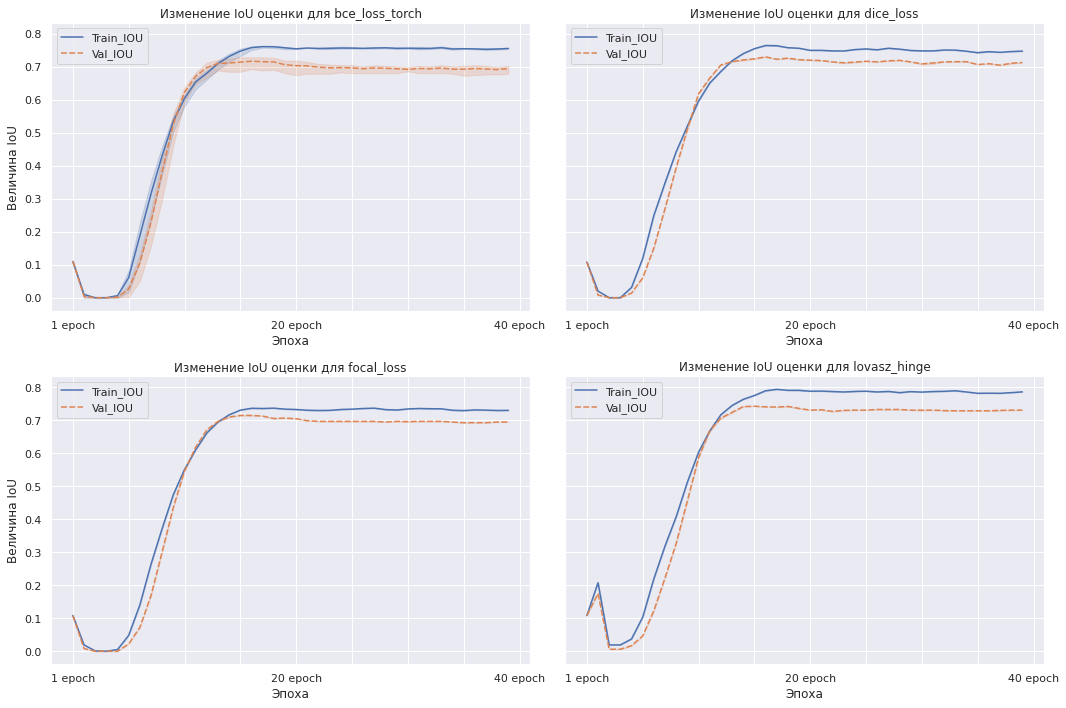

In [ ]:
loss_list = report['Loss_name'].unique().tolist()
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)

cnt = 5
for loss, ax in zip(loss_list, axes.flatten()):
    data = report.loc[report['Loss_name'] == loss][['Train_IOU', 'Val_IOU']]
    sns.lineplot(data=data, ax=ax, color=current_palette[cnt], estimator='mean')
    ax.set_title(f'Изменение IoU оценки для {loss}')
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[1] = '1 epoch'
    labels[5] = '20 epoch'
    labels[9] = '40 epoch'
    ax.set_xticklabels(labels)
    ax.set_ylabel('Величина IoU')
    ax.set_xlabel('Эпоха')
    cnt += 5
plt.tight_layout()

Мы наблюдаем достаточно идентичное поведение в плане роста IoU, но стоит отметить, что максимальной величины мы достигаем на `lovasz_hinge` и неплохо себя показывает `focal_loss` с `bce` - но стоит отметить

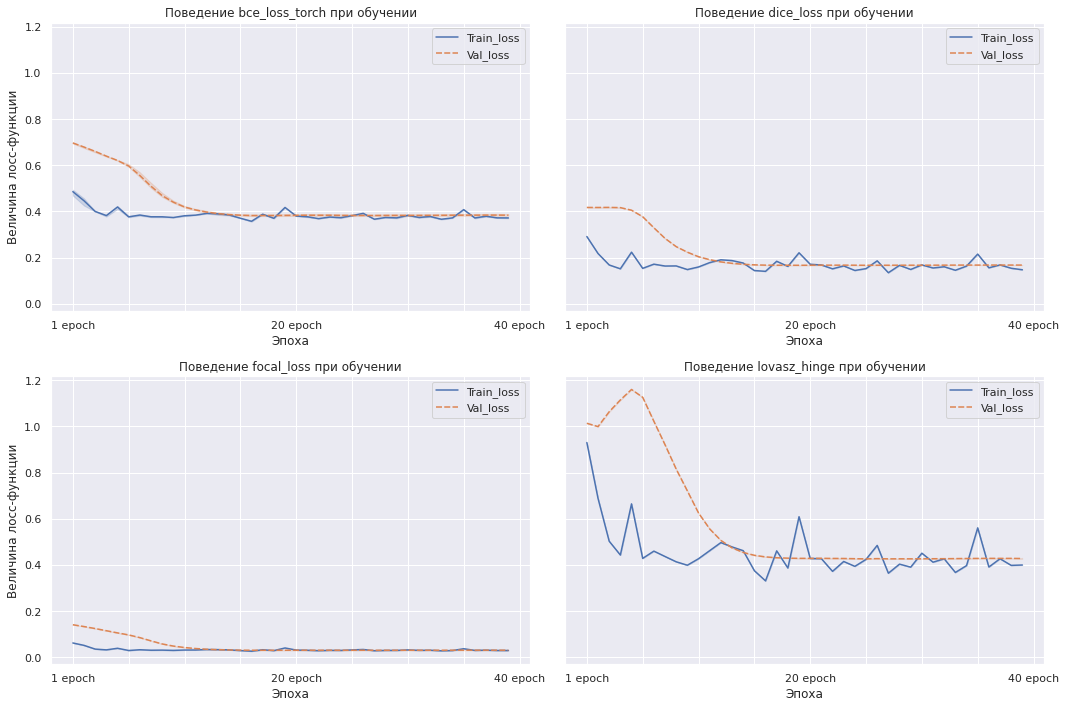

In [ ]:
loss_list = report['Loss_name'].unique().tolist()
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
cnt = 5
for loss, ax in zip(loss_list, axes.flatten()):
    data = report.loc[report['Loss_name'] == loss][['Train_loss', 'Val_loss']]
    sns.lineplot(data=data, ax=ax, color=current_palette[cnt])
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[1] = '1 epoch'
    labels[5] = '20 epoch'
    labels[9] = '40 epoch'
    ax.set_xticklabels(labels)
    ax.set_title(f'Поведение {loss} при обучении')
    ax.set_ylabel('Величина лосс-функции')
    ax.set_xlabel('Эпоха')

    cnt += 5
plt.tight_layout()

Здесь также наблюдаем аналогичные изменения - стоит отметить, что быстрее сходится `bce_loss_torch`

In [ ]:
for loss in loss_list:
 print()
 display(report.loc[report['Loss_name'] == loss][['Train_loss', 'Val_loss', 'Train_IOU', 'Val_IOU']]
         .describe().T.style.set_caption(f'Сводная таблица статистик для {loss}')
         )

Как мы видим, `lovasz_hinge` лидирует - достаточно стабильно показывает лучшие результаты

Таким образом, для задачи сегментации невуса лучше всего остановиться свой выбор на `lovasz_hinge` или `bce_loss_torch`


In [ ]:
(summary.style.highlight_max( 'IoU_test' , color = 'green' , axis = 0 )
    .highlight_max( 'IoU_validation' , color = 'grey' , axis = 0 )
    .highlight_min( 'val_test_diff' , color = 'blue' , axis = 0 )
    .set_caption('Сводная таблица результатов первичных испытания '
    ' для различных лосс-функций на архитектуре SeGNet и U-Net')
    .hide_index()
    )

Но если взять во внимание общие результаты на различных архитектурах моделей - наилучшую производительность показывают лоссы, работающие с пересечением. Таким образом, на производительность моделей в задачах сегментации сильное влияние оказывает не только архитектура, но и функция потерь, выбранная для оптимизации

Таким образом: 

- лучшая модель для сегментации изображений невуса - Архитектура на базе `U-Net с UpsamplingNearest2d` модулями. Дает меньше ошибок, более аккуратная к контурам. Но само по себе, архитектура влияет на ошибку не так сильно, как выбранный `loss`. В целом, если важно время предсказаний - выбор стоит оставновить на `U-net ConvTransposed2d`

- однозначно, стоит подбирать функцию для задачи сегментации под доменную область своих данных. Функции потерь оказывают сильное влияние на производительность сети. Например, `U-Net UpsamplingNearest2d с bce_loss_torch` показывает результаты хуже, чем `SegNeT с lovasz_hinge`. Но стоит использовать функцию потерь `lovasz_hinge` - и мы получаем значительный прирост к метрике

- лучшая функция потерь - `lovasz_hinge`, основанная на отсортированных ошибках. Работает с пересечениями и объединениями областей

<font size="1">
Примечание  

https://www.kaggle.com/artemsolomko    
https://leetcode.com/artysolomko/    
Telegramm @ArtyKraftyy   </font>   

<a href="#footer">К содержанию</a>
<footer id="footer"></footer>
